In [ ]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

#for deep learning

#import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Importing the training dataset adn initial preprocessing of the data
df = pd.read_csv(r"ec2metrics2020-09-08.csv",skipinitialspace=True,error_bad_lines=False)

df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
grouped_df = df.groupby("Timestamp")
grouped_df= df.pivot_table(index="Timestamp", columns="metric", values="Value", fill_value=0)





In [ ]:
grouped_df

metric,CPUUtilization,DiskReadBytes,DiskReadOps,DiskWriteBytes,DiskWriteOps,EBSByteBalance%,EBSIOBalance%,EBSReadBytes,EBSReadOps,EBSWriteBytes,EBSWriteOps,MetadataNoToken,NetworkIn,NetworkOut,NetworkPacketsIn,NetworkPacketsOut,StatusCheckFailed,StatusCheckFailed_Instance,StatusCheckFailed_System
Timestamp,,,,,,,,,,,,,,,,,,,
2020-08-25 21:52:00+00:00,0.0,0.0,0.0,0,0,99.200000,99.133333,0.0,0.0,408234.666667,80.133333,0,6988.133333,0.000000,43.066667,0.000000,0,0,0
2020-08-25 21:53:00+00:00,0.0,0.0,0.0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,0.000000,10282.200000,0.000000,45.733333,0,0,0
2020-08-25 22:07:00+00:00,0.0,0.0,0.0,0,0,99.133333,99.066667,0.0,0.0,100215.466667,17.533333,0,685.666667,0.000000,4.400000,0.000000,0,0,0
2020-08-25 22:08:00+00:00,0.0,0.0,0.0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,0.000000,1001.933333,0.000000,4.666667,0,0,0
2020-08-25 22:22:00+00:00,0.0,0.0,0.0,0,0,99.066667,99.066667,0.0,0.0,33860.266667,5.266667,0,0.000000,0.000000,0.000000,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-09 21:08:00+00:00,0.0,0.0,0.0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,0.000000,808.866667,0.000000,4.533333,0,0,0
2020-09-09 21:22:00+00:00,0.0,0.0,0.0,0,0,99.800000,99.800000,0.0,0.0,84377.600000,16.133333,0,465.533333,0.000000,3.733333,0.000000,0,0,0
2020-09-09 21:23:00+00:00,0.0,0.0,0.0,0,0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0,0.000000,735.200000,0.000000,3.200000,0,0,0


In [ ]:
grouped_df.columns

Index(['CPUUtilization', 'DiskReadBytes', 'DiskReadOps', 'DiskWriteBytes',
       'DiskWriteOps', 'EBSByteBalance%', 'EBSIOBalance%', 'EBSReadBytes',
       'EBSReadOps', 'EBSWriteBytes', 'EBSWriteOps', 'MetadataNoToken',
       'NetworkIn', 'NetworkOut', 'NetworkPacketsIn', 'NetworkPacketsOut',
       'StatusCheckFailed', 'StatusCheckFailed_Instance',
       'StatusCheckFailed_System'],
      dtype='object', name='metric')

In [ ]:
dataset_train = grouped_df[['EBSByteBalance%', 'EBSIOBalance%', 'EBSWriteBytes', 'EBSWriteOps','NetworkIn']]
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2880 entries, 2020-08-25 21:52:00+00:00 to 2020-09-09 21:38:00+00:00
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EBSByteBalance%  2880 non-null   float64
 1   EBSIOBalance%    2880 non-null   float64
 2   EBSWriteBytes    2880 non-null   float64
 3   EBSWriteOps      2880 non-null   float64
 4   NetworkIn        2880 non-null   float64
dtypes: float64(5)
memory usage: 135.0 KB


In [ ]:
dataset_train.head(10)



metric,EBSByteBalance%,EBSIOBalance%,EBSWriteBytes,EBSWriteOps,NetworkIn
Timestamp,,,,,
2020-08-25 21:52:00+00:00,99.200000,99.133333,408234.666667,80.133333,6988.133333
2020-08-25 21:53:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-25 22:07:00+00:00,99.133333,99.066667,100215.466667,17.533333,685.666667
2020-08-25 22:08:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-25 22:22:00+00:00,99.066667,99.066667,33860.266667,5.266667,0.000000
2020-08-25 22:23:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-25 22:37:00+00:00,99.266667,99.266667,237568.000000,10.600000,49703.133333
2020-08-25 22:38:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-25 22:52:00+00:00,99.333333,99.333333,28945.066667,4.333333,4.000000


In [ ]:
cols_of_interest = ['EBSByteBalance%', 'EBSIOBalance%', 'EBSWriteBytes', 'EBSWriteOps','NetworkIn']
dataset_train = dataset_train[(dataset_train[cols_of_interest]!=0).any(axis=1)]

In [ ]:
dataset_train['EBSByteBalance%'] = dataset_train[['EBSByteBalance%']].apply(lambda x : (x/100))
dataset_train['EBSIOBalance%'] = dataset_train[['EBSIOBalance%']].apply(lambda x : (x/100))

In [ ]:
dataset_train.head()


metric,EBSByteBalance%,EBSIOBalance%,EBSWriteBytes,EBSWriteOps,NetworkIn
Timestamp,,,,,
2020-08-25 21:52:00+00:00,0.992000,0.991333,408234.666667,80.133333,6988.133333
2020-08-25 22:07:00+00:00,0.991333,0.990667,100215.466667,17.533333,685.666667
2020-08-25 22:22:00+00:00,0.990667,0.990667,33860.266667,5.266667,0.000000
2020-08-25 22:37:00+00:00,0.992667,0.992667,237568.000000,10.600000,49703.133333
2020-08-25 22:52:00+00:00,0.993333,0.993333,28945.066667,4.333333,4.000000


In [ ]:
len(dataset_train)
dataset_train = dataset_train.reset_index()

In [ ]:
dataset_train["Timestamp"].dtype

datetime64[ns, UTC]

In [ ]:

dataset_train["Timestamp"] = dataset_train["Timestamp"].dt.strftime('%Y-%m-%d %H:%M:%S')
print(len(dataset_train))
print(type(dataset_train["Timestamp"]))
print(dataset_train.head())
print(dataset_train.info())

1440
<class 'pandas.core.series.Series'>
metric            Timestamp  EBSByteBalance%  ...  EBSWriteOps     NetworkIn
0       2020-08-25 21:52:00         0.992000  ...    80.133333   6988.133333
1       2020-08-25 22:07:00         0.991333  ...    17.533333    685.666667
2       2020-08-25 22:22:00         0.990667  ...     5.266667      0.000000
3       2020-08-25 22:37:00         0.992667  ...    10.600000  49703.133333
4       2020-08-25 22:52:00         0.993333  ...     4.333333      4.000000

[5 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Timestamp        1440 non-null   object 
 1   EBSByteBalance%  1440 non-null   float64
 2   EBSIOBalance%    1440 non-null   float64
 3   EBSWriteBytes    1440 non-null   float64
 4   EBSWriteOps      1440 non-null   float64
 5   NetworkIn        1440 non-null   float64
d

In [ ]:
dataset_train.to_csv("Cleaned_Input_data.csv")

In [ ]:
# We are predicting the EBSWriteBytes.

#select features to be involved into training and prediction.
cols = list(dataset_train)[1:6]
#print(cols)

# Extract dates(we will use them in visulaization)
datelist_train = list(dataset_train["Timestamp"])
print(datelist_train)
print('Training set shape = {}'.format(dataset_train.shape))
print("All timestamps = {}".format(len(datelist_train)))
print("Features selected: {}".format(cols))

['2020-08-25 21:52:00', '2020-08-25 22:07:00', '2020-08-25 22:22:00', '2020-08-25 22:37:00', '2020-08-25 22:52:00', '2020-08-25 23:07:00', '2020-08-25 23:22:00', '2020-08-25 23:37:00', '2020-08-25 23:52:00', '2020-08-26 00:07:00', '2020-08-26 00:22:00', '2020-08-26 00:37:00', '2020-08-26 00:52:00', '2020-08-26 01:07:00', '2020-08-26 01:22:00', '2020-08-26 01:37:00', '2020-08-26 01:52:00', '2020-08-26 02:07:00', '2020-08-26 02:22:00', '2020-08-26 02:37:00', '2020-08-26 02:52:00', '2020-08-26 03:07:00', '2020-08-26 03:22:00', '2020-08-26 03:37:00', '2020-08-26 03:52:00', '2020-08-26 04:07:00', '2020-08-26 04:22:00', '2020-08-26 04:37:00', '2020-08-26 04:52:00', '2020-08-26 05:07:00', '2020-08-26 05:22:00', '2020-08-26 05:37:00', '2020-08-26 05:52:00', '2020-08-26 06:07:00', '2020-08-26 06:22:00', '2020-08-26 06:37:00', '2020-08-26 06:52:00', '2020-08-26 07:07:00', '2020-08-26 07:22:00', '2020-08-26 07:37:00', '2020-08-26 07:52:00', '2020-08-26 08:07:00', '2020-08-26 08:22:00', '2020-08-2

In [ ]:
# convert dataset_train into matrix format
dataset_train = dataset_train[cols]
training_set = dataset_train.to_numpy()
print("The shape of the training_set = {}".format(training_set.shape))
training_set

The shape of the training_set = (1440, 5)


array([[9.92000000e-01, 9.91333333e-01, 4.08234667e+05, 8.01333333e+01,
        6.98813333e+03],
       [9.91333333e-01, 9.90666667e-01, 1.00215467e+05, 1.75333333e+01,
        6.85666667e+02],
       [9.90666667e-01, 9.90666667e-01, 3.38602667e+04, 5.26666667e+00,
        0.00000000e+00],
       ...,
       [9.98666667e-01, 9.98666667e-01, 8.73813333e+04, 1.65333333e+01,
        7.67933333e+02],
       [9.98000000e-01, 9.98000000e-01, 8.43776000e+04, 1.61333333e+01,
        4.65533333e+02],
       [9.97500000e-01, 9.97500000e-01, 1.43360000e+04, 2.16666667e+00,
        2.30769231e+01]])

In [ ]:
# Features Scaling
# One standard scaler for all dependent variables 
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

# one standard scaler for all independent variables.
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:,2:3])

array([[ 0.07403273],
       [-0.10532498],
       [-0.14396322],
       ...,
       [-0.11279822],
       [-0.11454728],
       [-0.15533208]])

In [ ]:
# create the data structure for training
X_train=[]
y_train=[]


In [ ]:
type(X_train)

list

In [ ]:
n_future=72
n_past=90

for i in range(n_past, len(training_set_scaled)-n_future+1):
  X_train.append(training_set_scaled[i-n_past:i, 0:dataset_train.shape[1]-1])
  y_train.append(training_set_scaled[i+n_future-1:i+n_future, 2])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape = {}".format(X_train.shape))
print("y_train shape = {}".format(y_train.shape))

X_train shape = (1279, 90, 4)
y_train shape = (1279, 1)


In [ ]:
#create the LSTM MOdel

model = Sequential()

# Adding the first LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding the second LSTM Layer
model.add(LSTM(units=64, return_sequences=False))

# Adding the drop-out layer to avoid over-fitting
model.add(Dropout(0.25))

# Adding the dense layer
model.add(Dense(1, activation='linear'))

#Compiling the neural network
model.compile(optimizer=Adam(lr=0.01), loss='mse')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 50,753
Trainable params: 50,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr =ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5',monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256 )

Epoch 1/30
1/4 [======>.......................] - ETA: 0s - loss: 1.1460WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4/4 [==============================] - ETA: 0s - loss: 0.9451
Epoch 00001: val_loss improved from inf to 1.66814, saving model to weights.h5
4/4 [==============================] - 2s 624ms/step - loss: 0.9451 - val_loss: 1.6681
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 0.8841
Epoch 00002: val_loss improved from 1.66814 to 1.65686, saving model to weights.h5
4/4 [==============================] - 1s 328ms/step - loss: 0.8841 - val_loss: 1.6569
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 0.8830
Epoch 00003: val_loss improved from 1.65686 to 1.65474, saving model to weights.h5
4/4 [==================

In [ ]:
# Make Future Predictions:

# make predictions for future dates

datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='15min').to_list()
print(datelist_train[-1])
print(datelist_future[-1])
print(datelist_future)

2020-09-09 21:37:00
2020-09-10 15:22:00
[Timestamp('2020-09-09 21:37:00', freq='15T'), Timestamp('2020-09-09 21:52:00', freq='15T'), Timestamp('2020-09-09 22:07:00', freq='15T'), Timestamp('2020-09-09 22:22:00', freq='15T'), Timestamp('2020-09-09 22:37:00', freq='15T'), Timestamp('2020-09-09 22:52:00', freq='15T'), Timestamp('2020-09-09 23:07:00', freq='15T'), Timestamp('2020-09-09 23:22:00', freq='15T'), Timestamp('2020-09-09 23:37:00', freq='15T'), Timestamp('2020-09-09 23:52:00', freq='15T'), Timestamp('2020-09-10 00:07:00', freq='15T'), Timestamp('2020-09-10 00:22:00', freq='15T'), Timestamp('2020-09-10 00:37:00', freq='15T'), Timestamp('2020-09-10 00:52:00', freq='15T'), Timestamp('2020-09-10 01:07:00', freq='15T'), Timestamp('2020-09-10 01:22:00', freq='15T'), Timestamp('2020-09-10 01:37:00', freq='15T'), Timestamp('2020-09-10 01:52:00', freq='15T'), Timestamp('2020-09-10 02:07:00', freq='15T'), Timestamp('2020-09-10 02:22:00', freq='15T'), Timestamp('2020-09-10 02:37:00', freq='

In [ ]:
type(datelist_future)

list

In [ ]:
# perform predictions

predictions_future = model.predict(X_train[-n_future:])
print(type(predictions_future))

<class 'numpy.ndarray'>


In [ ]:
# Inverse the predictions...remember we scaled the data.
y_pred_future = sc_predict.inverse_transform(predictions_future)
print(type(y_pred_future))
print(y_pred_future.shape)

<class 'numpy.ndarray'>
(72, 1)


In [ ]:
# make a clean dataframe of the results.
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=["EBSWriteBytes"]).set_index(pd.Series(datelist_future))

In [ ]:
type(datelist_future[0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
PREDICTIONS_FUTURE

,EBSWriteBytes
2020-09-09 21:37:00,-34104.531250
2020-09-09 21:52:00,-27672.562500
2020-09-09 22:07:00,-28553.218750
2020-09-09 22:22:00,2464.592773
2020-09-09 22:37:00,40234.406250
...,...
2020-09-10 14:22:00,-6403.813477
2020-09-10 14:37:00,9193.124023
2020-09-10 14:52:00,48615.687500
2020-09-10 15:07:00,65291.296875


In [ ]:
PREDICTIONS_FUTURE.to_csv("Predictions_EBSWriteBytes.csv")

In [ ]:
# Visualize the predictions
dataset_train_new = pd.DataFrame(dataset_train,columns=cols)
datelist_train_new = [pd.to_datetime(timestamp) for timestamp in datelist_train]
dataset_train_new.index = datelist_train_new


In [ ]:
dataset_train_new.head()

,EBSByteBalance%,EBSIOBalance%,EBSWriteBytes,EBSWriteOps,NetworkIn
2020-08-25 21:52:00,0.992000,0.991333,408234.666667,80.133333,6988.133333
2020-08-25 22:07:00,0.991333,0.990667,100215.466667,17.533333,685.666667
2020-08-25 22:22:00,0.990667,0.990667,33860.266667,5.266667,0.000000
2020-08-25 22:37:00,0.992667,0.992667,237568.000000,10.600000,49703.133333
2020-08-25 22:52:00,0.993333,0.993333,28945.066667,4.333333,4.000000


In [ ]:
dataset_train_new.tail()

,EBSByteBalance%,EBSIOBalance%,EBSWriteBytes,EBSWriteOps,NetworkIn
2020-09-09 20:37:00,0.998667,0.998667,25395.200000,4.666667,103.866667
2020-09-09 20:52:00,0.997333,0.997333,35498.666667,6.133333,20.800000
2020-09-09 21:07:00,0.998667,0.998667,87381.333333,16.533333,767.933333
2020-09-09 21:22:00,0.998000,0.998000,84377.600000,16.133333,465.533333
2020-09-09 21:37:00,0.997500,0.997500,14336.000000,2.166667,23.076923


In [ ]:
type(datelist_train_new[0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
dataset_train_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2020-08-25 21:52:00 to 2020-09-09 21:37:00
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EBSByteBalance%  1440 non-null   float64
 1   EBSIOBalance%    1440 non-null   float64
 2   EBSWriteBytes    1440 non-null   float64
 3   EBSWriteOps      1440 non-null   float64
 4   NetworkIn        1440 non-null   float64
dtypes: float64(5)
memory usage: 67.5 KB


In [ ]:
type(dataset_train_new.index)

pandas.core.indexes.datetimes.DatetimeIndex

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


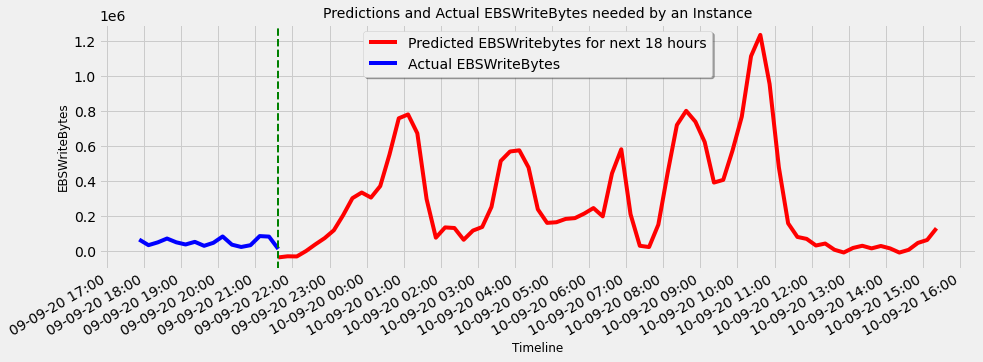

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,5)
plt.style.use('fivethirtyeight')
# plot parameters
START_TIMESTAMP_FOR_PLOTTING = datelist_train_new[-16]
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['EBSWriteBytes'], color='r', label='Predicted EBSWritebytes for next 18 hours')
ax.plot(dataset_train_new.loc[START_TIMESTAMP_FOR_PLOTTING:].index, dataset_train_new.loc[START_TIMESTAMP_FOR_PLOTTING:]['EBSWriteBytes'], color='b', label='Actual EBSWriteBytes')
plt.axvline(x=PREDICTIONS_FUTURE.index.min(), color='green', linewidth=2, linestyle='--')
hours = matplotlib.dates.HourLocator(interval = 1)
xfmt = matplotlib.dates.DateFormatter('%d-%m-%y %H:%M')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
plt.legend(shadow=True)
plt.title("Predictions and Actual EBSWriteBytes needed by an Instance", family='Arial', fontsize=14)
plt.xlabel('Timeline', family='Arial', fontsize=12)
plt.ylabel('EBSWriteBytes', family='Arial', fontsize=12)

plt.show()